### **2.1 : Data Generation**

In [1]:
import numpy as np
np.random.seed(0)
data = (2*np.random.uniform(size=(10000,2)))-1

In [2]:
import pandas as pd
df=pd.DataFrame(data)
display(df)

,0,1
0,0.097627,0.430379
1,0.205527,0.089766
2,-0.152690,0.291788
3,-0.124826,0.783546
4,0.927326,-0.233117
...,...,...
9995,0.073616,0.057428
9996,0.213897,0.410607
9997,0.907101,0.496349
9998,-0.403467,-0.107088


In [3]:
# Final Dataframe
Y=[]
for x,y in data:
  if x*y>0:
    z=0
  else:
    z=1
  Y.append(z)
df["Y"]=Y
df=df.rename(columns={0:'X1',1:'X2'})
display(df)

,X1,X2,Y
0,0.097627,0.430379,0
1,0.205527,0.089766,0
2,-0.152690,0.291788,1
3,-0.124826,0.783546,1
4,0.927326,-0.233117,1
...,...,...,...
9995,0.073616,0.057428,0
9996,0.213897,0.410607,0
9997,0.907101,0.496349,0
9998,-0.403467,-0.107088,0


### **2.2**

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

In [5]:
# Custom XOR Dataset Function

class XORdata(Dataset):

  def __init__(self,df):
    self.data=torch.FloatTensor(df.values.astype('float'))

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self,idx):
    inputs = self.data[idx][:-1]
    target = self.data[idx][-1]
    return inputs, target

In [6]:
# Datasets
from sklearn.model_selection import train_test_split
df2,df3 = train_test_split(df,test_size = 0.3)
df4,df5 = train_test_split(df3,test_size=0.5)
train=XORdata(df2)
val=XORdata(df4)
test=XORdata(df5)    

In [7]:
# Dataloaders
dl_train=DataLoader(train, batch_size=16, shuffle=True)
dl_val=DataLoader(val, batch_size=16, shuffle=True)
dl_test=DataLoader(test, batch_size=16, shuffle=True)

In [8]:
# Neural Network Function for XOR Data

import torch.nn as nn
import torch.nn.functional as F

class XORNN(nn.Module):

    def __init__(self, hidden_dim = 4):
        super(XORNN, self).__init__()
        self.lin1 = nn.Linear(2, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

In [9]:
from sklearn.metrics import accuracy_score as asc
import torch.optim as opti
model = XORNN()
lossf = nn.MSELoss()
optimiser = opti.SGD(model.parameters(), lr=0.001)

In [10]:
# Training Function

def Train(model,lossf,optimiser):

  model.train()
  tot_loss=0
  y_true = []
  y_pred = []

  for dl in dl_train:

    inputs, target = dl
    output = model(inputs)
    target = target.unsqueeze(1)
    loss = lossf(output,target)
    tot_loss+=loss
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    m = nn.Sigmoid()
    squashed = m(output)
    pred = np.round(squashed.detach().numpy())
    y_true.extend(target.tolist())
    y_pred.extend(pred.reshape(-1).tolist())

  net_loss=tot_loss/len(dl_train)
  accuracy=asc(y_true,y_pred)
  return net_loss, accuracy

In [11]:
# Validation Function

def Validate(model,lossf):

  model.eval()
  tot_loss=0
  y_true = []
  y_pred = []

  with torch.no_grad():

    for dl in dl_val:

      inputs, target = dl
      output = model(inputs)
      target = target.unsqueeze(1)
      loss = lossf(output,target)
      tot_loss+=loss
      m = nn.Sigmoid()
      squashed = m(output)
      pred = np.round(squashed)  
      y_true.extend(target.tolist()) 
      y_pred.extend(pred.reshape(-1).tolist())

    net_loss=tot_loss/len(dl_val)
    accuracy=asc(y_true,y_pred)
    return net_loss, accuracy  

In [12]:
n_epochs = 100
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]

for epoch in range(1,n_epochs+1):

  train_loss,train_accuracy = Train(model,lossf,optimiser)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  val_loss,val_accuracy = Validate(model,lossf)
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

Text(0.5, 1.0, 'Training & Validation Loss vs Epochs')

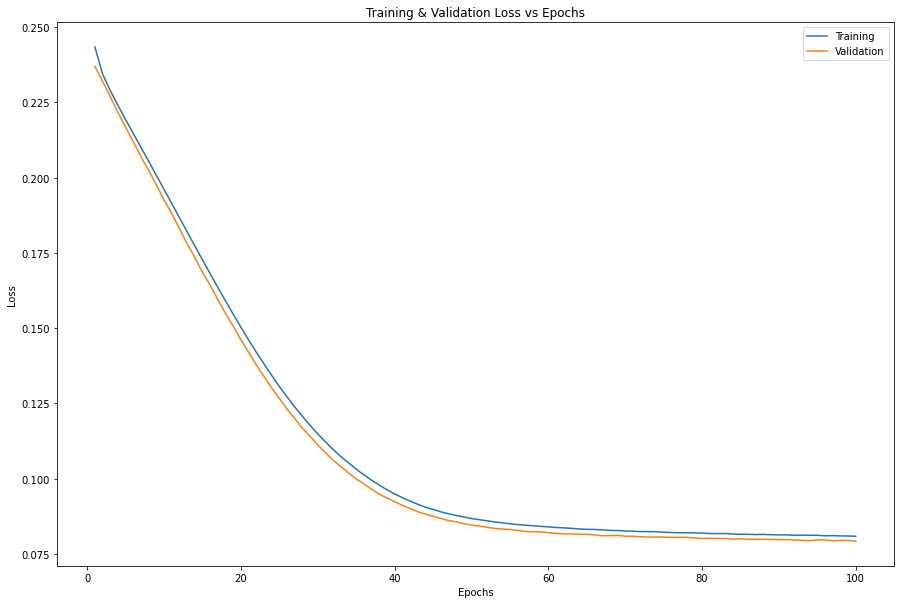

In [13]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots(figsize=(15,10))
plt.plot(range(1,101),train_losses)
plt.plot(range(1,101),val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training','Validation'])
plt.title('Training & Validation Loss vs Epochs')

Text(0.5, 1.0, 'Training & Validation Accuracy vs Epochs')

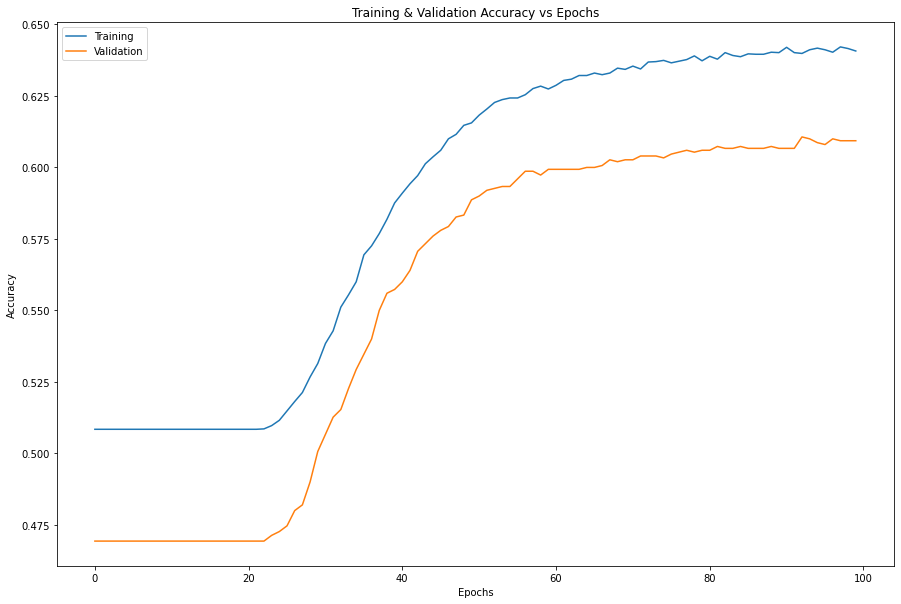

In [14]:
fig,ax=plt.subplots(figsize=(15,10))
plt.plot(range(100),train_accuracies)
plt.plot(range(100),val_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training','Validation'])
plt.title('Training & Validation Accuracy vs Epochs')

In [15]:
def TVLA(model,lossf,optimiser,n_epochs):

  TL,VL,TA,VA=[],[],[],[]

  for epoch in range(1,n_epochs+1):

    tl,ta = Train(model,lossf,optimiser)
    TL.append(tl)
    TA.append(ta)
    vl,va = Validate(model,lossf)
    VL.append(vl)
    VA.append(va)
  
  return TL,VL,TA,VA

In [16]:
HLS=[2,4,6,8,10]
BVL=[]
for size in HLS:
  model=XORNN(size)
  optimiser = opti.SGD(model.parameters(), lr=0.001)
  Val_Losses=TVLA(model,lossf,optimiser,100)[2]
  BVL.append(min(Val_Losses))

Text(0.5, 1.0, 'Best Validation Loss vs Hidden Layer size')

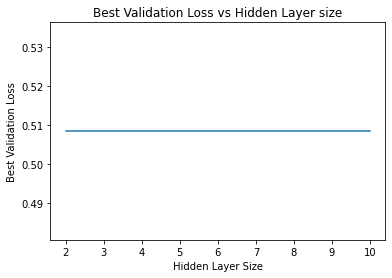

In [17]:
plt.plot(HLS,BVL)
plt.xlabel('Hidden Layer Size')
plt.ylabel('Best Validation Loss')
plt.title('Best Validation Loss vs Hidden Layer size')

In [18]:
BVL2=[]
LR=[0.00001,0.0001,0.001,0.01,0.1]
for lr in LR:
  optimiser = opti.SGD(model.parameters(),lr)
  Val_Losses=TVLA(model,lossf,optimiser,20)[2]
  BVL2.append(min(Val_Losses))

Text(0.5, 1.0, 'Best Validation Loss vs Learning Rate')

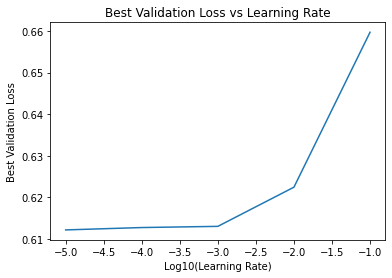

In [19]:
plt.plot(np.log10(LR),BVL2)
plt.xlabel('Log10(Learning Rate)')
plt.ylabel('Best Validation Loss')
plt.title('Best Validation Loss vs Learning Rate')

In [20]:
BVL2

[0.6121428571428571,
 0.6127142857142858,
 0.613,
 0.6224285714285714,
 0.6597142857142857]

In [21]:
# Testing

model.eval()
tot_loss=0
y_true = []
y_pred = []
optimiser = opti.SGD(model.parameters(),0.00001)
TVLA(model,lossf,optimiser,100)

with torch.no_grad():

  for dl in dl_test:
    
    inputs, target = dl
    output = model(inputs)
    target = target.unsqueeze(1)
    loss = lossf(output,target)
    tot_loss+=loss
    pred = np.round(output)  
    y_true.extend(target.tolist()) 
    y_pred.extend(pred.reshape(-1).tolist())

  net_loss=tot_loss/len(dl_val)
  accuracy=asc(y_true,y_pred)

In [22]:
print(accuracy,net_loss)

0.984 tensor(0.0314)


In [30]:
df6 = df5
y_pred2 = [int(x) for x in y_pred]
df6['Y_pred'] = y_pred2
df6 = df6.rename(columns={'Y':'Y_true'})
display(df6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,X1,X2,Y_true,Y_pred
4759,0.798913,-0.182639,1,0
3006,0.727195,0.720770,0,0
8756,-0.438123,0.685271,1,1
2698,-0.249222,-0.741061,0,1
4572,0.770533,-0.248396,1,1
...,...,...,...,...
3355,0.406289,-0.311197,1,0
1833,-0.608262,-0.710546,0,1
3431,-0.649568,0.505917,1,1
4963,0.023172,-0.102662,1,1


In [31]:
# Testing

model.eval()
tot_loss=0
y_true = []
y_pred = []
optimiser = opti.SGD(model.parameters(),0.00001)
TVLA(model,lossf,optimiser,100)

with torch.no_grad():

  for dl in dl_test:
    
    inputs, target = dl
    output = model(inputs)
    target = target.unsqueeze(1)
    loss = lossf(output,target)
    tot_loss+=loss
    m = nn.Sigmoid()
    squashed = m(output)
    pred = np.round(squashed) 
    y_true.extend(target.tolist()) 
    y_pred.extend(pred.reshape(-1).tolist())

  net_loss=tot_loss/len(dl_val)
  accuracy=asc(y_true,y_pred)

In [32]:
print(accuracy,net_loss)

0.718 tensor(0.0313)


In [33]:
df6 = df5
y_pred2 = [int(x) for x in y_pred]
df6['Y_pred'] = y_pred2
df6 = df6.rename(columns={'Y':'Y_true'})
display(df6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,X1,X2,Y_true,Y_pred
4759,0.798913,-0.182639,1,1
3006,0.727195,0.720770,0,1
8756,-0.438123,0.685271,1,1
2698,-0.249222,-0.741061,0,0
4572,0.770533,-0.248396,1,1
...,...,...,...,...
3355,0.406289,-0.311197,1,1
1833,-0.608262,-0.710546,0,1
3431,-0.649568,0.505917,1,0
4963,0.023172,-0.102662,1,1
